In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from torch.utils.data import ConcatDataset

import pywt
from scipy.signal import welch
from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    silhouette_score,
)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap
from imblearn.over_sampling import SMOTE
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from collections import Counter

In [2]:
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True) 
        std[std == 0] = 1e-8  
        
        return signal

    @staticmethod
    def resample(signal: np.ndarray,
                 factor: int,
                 method: str = 'mean') -> np.ndarray:
        """
        Downsample a multi-channel signal by aggregating each `factor` points into one.
    
        Args:
            signal: 2D array of shape (channels, time).
            factor: Number of consecutive points to aggregate (e.g., 12 to go from 5 min to 1 h).
            method: Aggregation method—either 'mean' or 'sum'.
    
        Returns:
            2D array of shape (channels, time//factor) with aggregated values.
    
        Note:
            This uses NumPy’s default aggregation behavior. If any NaN values are present
            within a group of `factor` points, the result for that group will be NaN.
            To ignore NaNs instead, you could replace `reshaped.mean(...)` with
            `np.nanmean(reshaped, axis=2)`.
        """
        # Number of EEG channels and original time length
        channels, length = signal.shape
    
        # Determine how many full groups of `factor` fit into the signal
        new_length = length // factor
    
        # Truncate any extra points so length is exactly divisible by factor
        trimmed = signal[:, : new_length * factor]
    
        # Reshape to (channels, new_length, factor) so we can aggregate over the last axis
        reshaped = trimmed.reshape(channels, new_length, factor)
    
        if method == 'mean':
            # Compute the average of each group of `factor` points
            return reshaped.mean(axis=2)
        elif method == 'sum':
            # Compute the sum of each group of `factor` points
            return reshaped.sum(axis=2)
        else:
            raise ValueError(f"Unsupported method: {method}")

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis
    

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz'],time_resolution='5min'):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment 
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=start_time
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
       
        # 计算下采样因子
        if time_resolution == '1h':
            self.resample_factor = 60 // 5  # 12
        else:
            self.resample_factor = 1
       
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules    
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly
        
        if self.resample_factor > 1:
            augmented_signal = EEGUtil.resample(augmented_signal,
                                     factor=self.resample_factor,
                                     method='mean')

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count
    

In [7]:
data_folder = '5min_smoothed_data/'  # 换成你的路径

# —— 1. 扫描所有 CSV 文件，收集列名并去掉 cpc —— 
all_columns = set()
for fname in os.listdir(data_folder):
    if fname.endswith('.csv'):
        df0 = pd.read_csv(os.path.join(data_folder, fname), nrows=0)
        all_columns.update(df0.columns.tolist())
cols = sorted(all_columns)
for drop in ['cpc', 'pat_ID', 'timestamp_hour']:
    if drop in cols:
        cols.remove(drop)

# —— 2. 从示例文件筛选数值型列 —— 
example_csv = next(f for f in os.listdir(data_folder) if f.endswith('.csv'))
example_df  = pd.read_csv(os.path.join(data_folder, example_csv), nrows=10)

numeric_cols = [
    col for col in cols
    if pd.api.types.is_numeric_dtype(example_df[col])
]

print("▶️ 最终用作 column_names 的数值型列 (共 {} 列)：".format(len(numeric_cols)))
print(numeric_cols)

▶️ 最终用作 column_names 的数值型列 (共 95 列)：
['BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD', 'alphakurtosis', 'alphameanrat', 'alphaminrat', 'alphapctrat', 'alphastdrat', 'avgspectent', 'avgspectkurt', 'betakurtosis', 'betameanrat', 'betaminrat', 'betapctrat', 'betastdrat', 'corrmean', 'd0MaxAmp', 'd0MaxMaxFourAmp', 'd0MeanMaxAmp', 'd0MeanMaxFourAmp', 'd0MeanVarAmp', 'd0VarMaxAmp', 'd0VarMaxFourAmp', 'd0VarMeanAmp', 'd0VarVarAmp', 'd1MaxAmp', 'd1MaxMaxFourAmp', 'd1MeanMaxAmp', 'd1MeanMaxFourAmp', 'd1MeanVarAmp', 'd1VarMaxAmp', 'd1VarMaxFourAmp', 'd1VarMeanAmp', 'd1VarVarAmp', 'd2MaxAmp', 'd2MaxMaxFourAmp', 'd2MeanMaxAmp', 'd2MeanMaxFourAmp', 'd2MeanVarAmp', 'd2VarMaxAmp', 'd2VarMaxFourAmp', 'd2VarMeanAmp', 'd2VarVarAmp', 'deltaalphamean', 'deltaalphamin', 'deltaalphapct', 'deltaalphastd', 'deltakurtosis', 'deltameanrat', 'deltaminrat', 'deltapctrat', 'deltastdrat', 'deltathetamean', 'deltathetamin', 'deltathetapct', 'deltathetastd', 'geomeanamp', 'harmmean

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GroupKFold

# —— 0. 设备设置 —— 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# —— 1. 超参数与数据集初始化 —— 
start_time   = 16
seq_length   = (68 - start_time) * 12  # 624 个 5min 窗口
column_names =numeric_cols
#column_names = ['BCI']
batch_size   = 32
epochs       = 100
n_splits     = 5
learning_rate= 1e-3
time_resolution='1h'   # 新增参数：'5min' 或 '1h'


# 创建 EEGDataset
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file='files_art_ssd_fts_predictions.csv',
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode='constant',
    use_labels=True,
    augment=False,
    num_good=1,
    num_bad=1,
    column_names=column_names,
    time_resolution=time_resolution
)

cuda
✅ Loaded 244 valid EEG files (filtered from 244 total)
Good Outcome: 44, Bad Outcome: 200


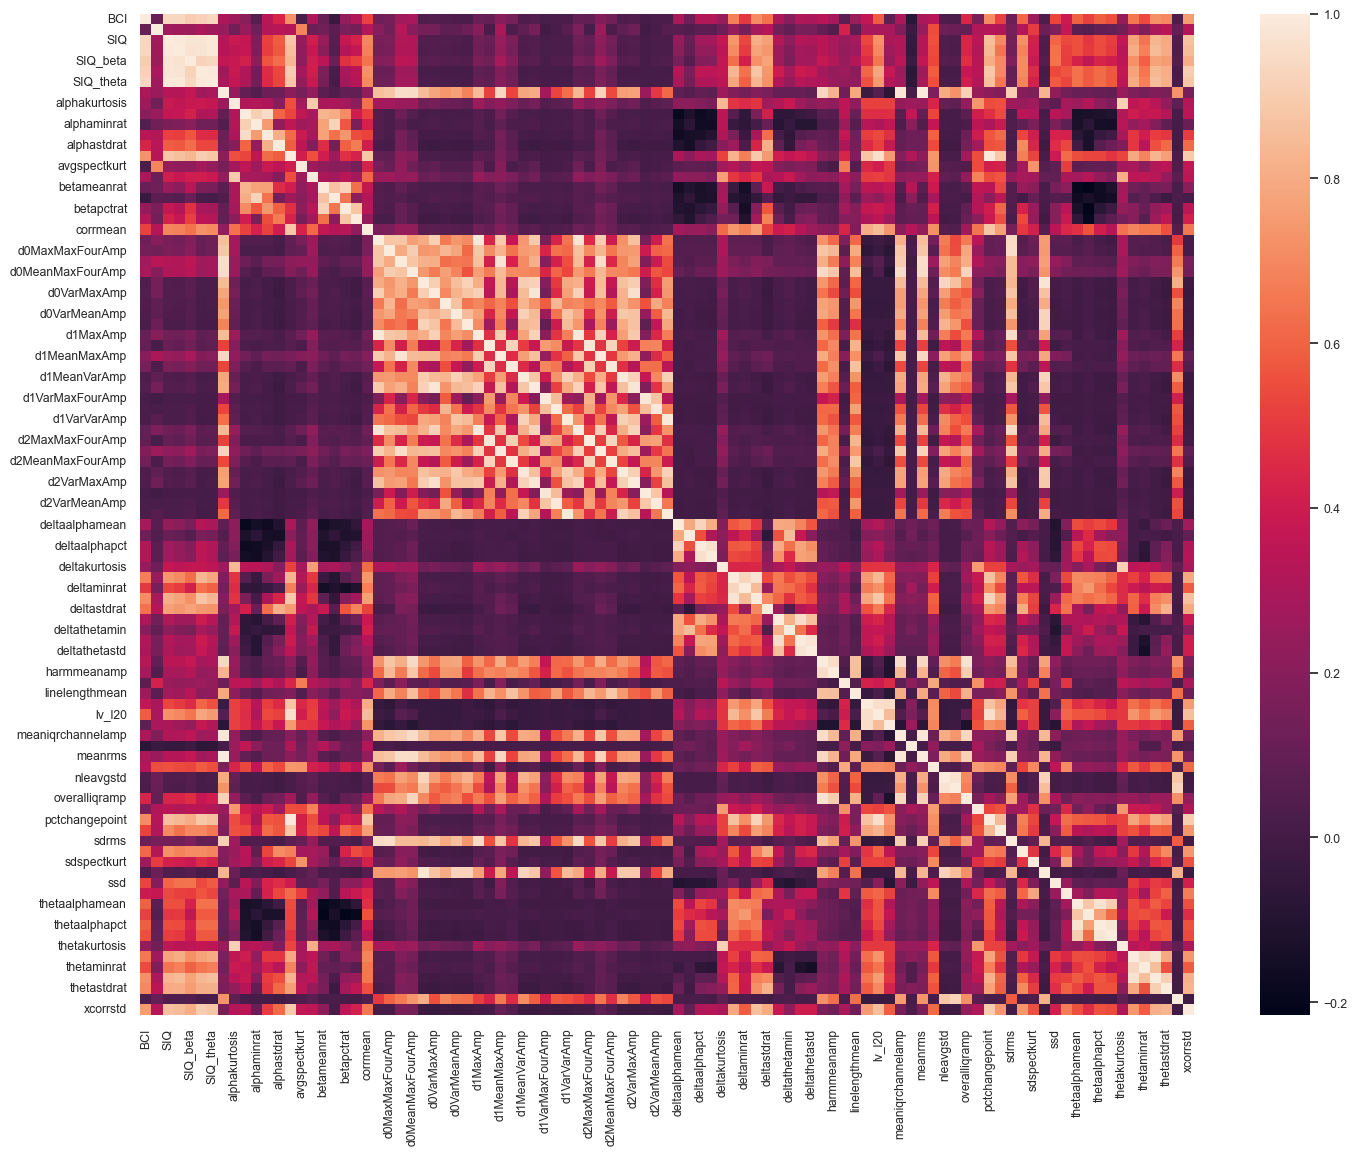

In [17]:
# —— 1. 把所有样本拆成 (patient, hour) 记录 —— 
records = []
for idx in range(len(eeg_dataset)):
    sig_tensor, label = eeg_dataset[idx]       # sig_tensor: (channels, 52)
    sig = sig_tensor.numpy()
    orig_idx, _ = eeg_dataset.expanded_indices[idx]
    filename, _ = eeg_dataset.valid_files[orig_idx]
    pat_id = filename.split('.')[0]
    
    for hour in range(sig.shape[1]):           # 0 … 51
        row = {
            'pat_ID': pat_id,
            'hour':   hour,
            'cpc':    label
        }
        # 把所有特征列打平
        for ch, feat_name in enumerate(eeg_dataset.column_names):
            row[feat_name] = sig[ch, hour]
        records.append(row)

all_feature_data = pd.DataFrame(records)

# —— 2. 跑你原来那段下游分析 —— 
X = all_feature_data.drop(columns=['cpc', 'pat_ID', 'hour'])
y = all_feature_data['cpc'].apply(lambda val: 'good' if val == 1 else 'poor').to_numpy()

# 相关性热图
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(17,13))
sns.set_style('whitegrid'); sns.set_theme(font_scale=0.8)
df_corr = X.corr()
sns.heatmap(df_corr, annot=False)
plt.savefig("corr_plot.png", dpi=300)

# 高相关特征剔除
removal_threshold = 0.95
upper = df_corr.abs().where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if (upper[col] > removal_threshold).any()]
X.drop(to_drop, axis=1, inplace=True)

# RF 特征重要性
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

feature_names = X.columns.tolist()
feats = dict.fromkeys(feature_names, 0.0)
X_scaled = MinMaxScaler().fit_transform(X)

for i in range(X_scaled.shape[1]):
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    rf.fit(X_scaled, y)
    for fn, imp in zip(feature_names, rf.feature_importances_):
        feats[fn] += imp

# 平均并存盘
feats = {fn: sc/X_scaled.shape[1] for fn, sc in feats.items()}
pd.DataFrame.from_dict(feats, orient='index', columns=['Score']) \
   .sort_values('Score', ascending=False) \
   .to_csv("feature_ranking.csv")

In [20]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans

# —— 1. 把 feats（dict）转成 DataFrame —— 
# feats 是一个 {feature_name: score} 的字典
feats_df = pd.DataFrame({
    'Feature': list(feats.keys()),
    'Score':   list(feats.values())
})

# —— 2. 选出 top-3 —— 
top_features = feats_df.nlargest(3, 'Score')['Feature'].tolist()
print("Top 3 features:", top_features)

# —— 3. 重建 metadata —— 
metadata = all_feature_data[['pat_ID', 'cpc']].drop_duplicates().reset_index(drop=True)

# —— 4. 为每个 top feature 构造时序阵列 —— 
feature_arrays = []
max_length = 0
for feature in top_features:
    df_pivot = all_feature_data.pivot(index='pat_ID', columns='hour', values=feature)
    # 每个患者的时间序列（忽略 NaN）
    seqs = [df_pivot.loc[pid].dropna().tolist() for pid in df_pivot.index]
    max_length = max(max_length, max(len(s) for s in seqs))
    # pad NaNs 到相同长度
    padded = [s + [np.nan]*(max_length - len(s)) for s in seqs]
    feature_arrays.append(np.array(padded))  # shape=(n_patients, max_length)

# —— 5. 堆叠成 (patients, time, features) 并归一化 —— 
X_3D = np.stack(feature_arrays, axis=-1)
normalized_data = TimeSeriesScalerMinMax().fit_transform(X_3D)

# —— 6. DTW 聚类 —— 
n_clusters = 3
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
clusters = km.fit_predict(normalized_data)

cluster_df = pd.DataFrame({
    'pat_ID': metadata['pat_ID'],
    'cluster': clusters
})
cluster_df.to_csv("clusters.csv", index=False)

# —— 7. 可视化 —— 
for feature_idx, feature_name in enumerate(top_features):
    plt.figure(figsize=(5, 15))
    good_counts = []
    bad_counts = []

    for cluster_id in range(n_clusters):
        plt.subplot(n_clusters, 1, cluster_id + 1)
        idxs = np.where(clusters == cluster_id)[0]

        # —— 在这里初始化 —— 
        cluster_seqs = []

        # 统计好/坏样本数
        good = np.sum(metadata['cpc'].iloc[idxs] == 1)
        bad  = len(idxs) - good
        good_counts.append(good)
        bad_counts.append(bad)

        # 画每个患者的曲线
        for i in idxs:
            seq = X_3D[i, :, feature_idx]
            color, alpha = ('green', 0.6) if metadata['cpc'].iloc[i] == 1 else ('red', 0.4)
            plt.plot(seq, c=color, alpha=alpha)
            cluster_seqs.append(seq)

        # 如果这一簇有序列，再计算并画出平均曲线
        if cluster_seqs:
            mean_seq = np.nanmean(np.vstack(cluster_seqs), axis=0)
            plt.plot(mean_seq, c='black', alpha=0.9)

        plt.xticks(
            ticks=np.linspace(0, X_3D.shape[1] - 1, num=5),
            labels=np.arange(start_time, start_time + X_3D.shape[1]//12 + 1, step=13)
        )
        plt.xlabel('Hour')
        plt.ylabel(feature_name)
        plt.title(f'Feature: {feature_name} | Cluster {cluster_id + 1}')

    plt.tight_layout()
    plt.savefig(f'eeg_signals_dtw_cluster_{feature_name}.png', dpi=300)
    plt.close()

# 最后再画一次堆叠柱状图
cluster_labels = [f"Cluster {i+1}" for i in range(n_clusters)]
plt.figure(figsize=(15, 5))
plt.bar(cluster_labels, good_counts, color='green', label='Good Outcome')
plt.bar(cluster_labels, bad_counts, bottom=good_counts, color='red', label='Poor Outcome')
plt.title("Proportion of Good vs. Poor Outcomes")
plt.xlabel("Clusters")
plt.ylabel("Patient Count")
plt.legend()
plt.tight_layout()
plt.savefig('eeg_signals_dtw_cluster_bar.png', dpi=300)
plt.close()

Top 3 features: ['meanskewamp', 'kurtavg', 'corrmean']


C:\Users\admin\AppData\Local\Temp\ipykernel_1420\87296693.py:73: RuntimeWarning: Mean of empty slice
  mean_seq = np.nanmean(np.vstack(cluster_seqs), axis=0)
